# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Boltzmann-Simulation" data-toc-modified-id="Boltzmann-Simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Boltzmann Simulation</a></div><div class="lev2 toc-item"><a href="#Pentose-phosphate-+-Glycolysis-+-TCA-cycle" data-toc-modified-id="Pentose-phosphate-+-Glycolysis-+-TCA-cycle-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pentose phosphate + Glycolysis + TCA cycle</a></div><div class="lev1 toc-item"><a href="#Models-and-Simulations" data-toc-modified-id="Models-and-Simulations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models and Simulations</a></div><div class="lev2 toc-item"><a href="#Model-Without-Regulation" data-toc-modified-id="Model-Without-Regulation-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Without Regulation</a></div><div class="lev3 toc-item"><a href="#Run-Deterministic-Simulation" data-toc-modified-id="Run-Deterministic-Simulation-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Run Deterministic Simulation</a></div><div class="lev3 toc-item"><a href="#Derivatives-from-ODE-thermodynamic-optimization-simulation" data-toc-modified-id="Derivatives-from-ODE-thermodynamic-optimization-simulation-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Derivatives from ODE thermodynamic optimization simulation</a></div><div class="lev3 toc-item"><a href="#Thermodynamic-Odds-of-Reaction-from-Deterministic-Simulation" data-toc-modified-id="Thermodynamic-Odds-of-Reaction-from-Deterministic-Simulation-213"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Thermodynamic Odds of Reaction from Deterministic Simulation</a></div><div class="lev3 toc-item"><a href="#Calculate-Net-Odds" data-toc-modified-id="Calculate-Net-Odds-214"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Calculate Net Odds</a></div><div class="lev3 toc-item"><a href="#Map-Net-Likelihoods-onto-Metabolic-Pathways" data-toc-modified-id="Map-Net-Likelihoods-onto-Metabolic-Pathways-215"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Map Net Likelihoods onto Metabolic Pathways</a></div><div class="lev3 toc-item"><a href="#Find-Active-and-Variable-Metabolites" data-toc-modified-id="Find-Active-and-Variable-Metabolites-216"><span class="toc-item-num">2.1.6&nbsp;&nbsp;</span>Find Active and Variable Metabolites</a></div><div class="lev3 toc-item"><a href="#Time-Derivatives-of-Metabolite-Concentration:-S-cdot-Net-Odds-=-flux" data-toc-modified-id="Time-Derivatives-of-Metabolite-Concentration:-S-cdot-Net-Odds-=-flux-217"><span class="toc-item-num">2.1.7&nbsp;&nbsp;</span>Time Derivatives of Metabolite Concentration: S $\cdot$ Net Odds = flux</a></div><div class="lev3 toc-item"><a href="#Analyze-Variable-Metabolite-Levels-from-Deterministic-Simulation" data-toc-modified-id="Analyze-Variable-Metabolite-Levels-from-Deterministic-Simulation-218"><span class="toc-item-num">2.1.8&nbsp;&nbsp;</span>Analyze Variable Metabolite Levels from Deterministic Simulation</a></div><div class="lev2 toc-item"><a href="#Infer-Regulated-Reactions" data-toc-modified-id="Infer-Regulated-Reactions-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Infer Regulated Reactions</a></div>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import re
import os
from IPython.core.display import display
pd.set_option('display.max_columns', None,'display.max_rows', None)
#from ipynb_latex_setup import *
%matplotlib inline
#%matplotlib pdf
#matplotlib.matplotlib_fname()
#import matplotlib.rcsetup as rcsetup
#print(rcsetup.all_backends)
T = 298.15
R = 8.314e-03
RT = R*T
N_avogadro = 6.022140857e+23
VolCell = 1.0e-15
Concentration2Count = N_avogadro * VolCell
concentration_increment = 1/(N_avogadro*VolCell)

Change directories to where the simulation data is:

In [38]:
# Comment/uncomment to change to your directory, if needed:
cwd = os.getcwd()
mydir = cwd+'/simulation_data'
if 'simulation_data' not in mydir: 
  os.chdir(mydir)

# Boltzmann Simulation
A beta version of the simulation code is available on GitHub at https://github.com/PNNL-CompBio/Boltzmann.
## Pentose phosphate + Glycolysis + TCA cycle
Model input file (Reactions):

In [39]:
cat neurospora_pentose_phos.glycolysis.tca.2.dat

REACTION ME1m
LEFT	(S)-MALATE + NAD+ 
RIGHT	pyruvate + NADH + CO2
LEFT_COMPARTMENT MITOCHONDRIA
RIGHT_COMPARTMENT MITOCHONDRIA
ENZYME_LEVEL	0.0
//
REACTION ME2m
LEFT    (S)-MALATE + NADP+
RIGHT   PYRUVATE + NADPH + CO2
LEFT_COMPARTMENT MITOCHONDRIA
RIGHT_COMPARTMENT MITOCHONDRIA
ENZYME_LEVEL	0.0
//
REACTION CSm
LEFT	OXALOACETATE + ACETYL-COA + H2O
RIGHT	CITRATE + COA
LEFT_COMPARTMENT MITOCHONDRIA
RIGHT_COMPARTMENT MITOCHONDRIA
COMMENT	PH = 7.0, IONIC STRENGTH = 0.15 M 
//
REACTION ACONTm
LEFT	CITRATE
RIGHT	ISOCITRATE
LEFT_COMPARTMENT MITOCHONDRIA
RIGHT_COMPARTMENT MITOCHONDRIA
COMMENT	 PH = 7.0, IONIC STRENGTH = 0.15 M 
COMMENT DOn't split into two reactions if max entropy is being used - only one enzyme needs to be epressed
//
REACTION ICDHxm
LEFT	ISOCITRATE + NAD+
RIGHT	2-OXOGLUTARATE + NADH + CO2
LEFT_COMPARTMENT MITOCHONDRIA
RIGHT_COMPARTMENT MITOCHONDRIA
COMMENT	PH = 7.0, IONIC STRENGTH = 0.15 M
//
REACTION AKGDm
LEFT	2-OXOGLUTARATE + COA + NAD+
RIGHT	SUCCINYL-COA + CO2 + NADH
LEF

Boltzmann Input File:

In [40]:
cat neurospora_pentose_phos.glycolysis.tca_reg.in

RXN_FILE neurospora_pentose_phos.glycolysis.tca.2.dat
INIT_FILE neurospora_pentose_phos.glycolysis.tca.2_reg.rstrt
INIT_FILE yeast_centralMetab_concs2.in 
INIT_FILE neurospora_pentose_phos.glycolysis.tca_concs.in
INIT_FILE neurospora_pentose_phos.glycolysis.tca.2_reg.rstrt
LOG_FILE neurospora_pentose_phos.glycolysis.tca.2_reg.log
OUT_FILE neurospora_pentose_phos.glycolysis.tca.2_reg.out
USE_DEQ 1
NO_ROUND_FROM_DEQ 1
ODE_T_FINAL 100000
DELTA_CONCS_CHOICE 13
DELTA_CONCS_CHOICE 8
DERIV_THRESH  5.0e-17
ODE_RXN_VIEW_FREQ 1
WARMUP_STEPS 00000000
RECORD_STEPS 000000
TEMP_KELVIN 298.15
PH 7.0
IONIC_STRENGTH 0.15
PRINT_OUTPUT 2
CONCS_OR_COUNTS 3
RXN_VIEW_FREQ 100
COUNT_VIEW_FREQ 100
LKLHD_VIEW_FREQ 100
USE_BULK_WATER 1
USE_REGULATION 1
USE_ENZYME_LEVELS 1
USE_PSEUDOISOMERS 1
USE_DGZERO 1
USE_ACTIVITIES 1
NUM_METABOLIC_GROUPS 1



# Models and Simulations

## Model Without Regulation
### Run Deterministic Simulation
Uncomment the lines below to run Boltzmann from the Jupyter notebook. We prefer not to run from the notebook because it may take several runs before the system converges.

In [41]:
#args = ("boltzmann", "neurospora_pentose_phos.glycolysis.tca_no_reg.in")
#popen = subprocess.Popen(args, stdout=subprocess.PIPE)
#popen.wait()
#output = popen.stdout.read()
#print(output)

### Derivatives from ODE thermodynamic optimization simulation
For the maximum entropy optimization without any regulation, multiple rounds of optimization were used to obtain sufficiently converged derivatives. The maximum entropy distribution has a wide range of metabolite concentrations, from $10^{-22}$ for oxaloacetate to $10^{6}M$ for fructose-1,6-bisphosphate and $10^{9}M$ for acetyl-CoA. Despite these large differences, derivatives remain stable until the the derivatives for acetyl-CoA go below 0.05. At this point the solver becomes unstable because even a small time step results in a large change the derivative. However, the derivatives are sufficiently converged at this point that the loss function can be applied to the metabolite levels to infer reactions that should be regulated. To put this another way, it does not matter for the purpose of infering regulation if the acetyl-CoA concentraion is $1.0\cdot10^{9}$ or $6.0\cdot10^{9}$, both are well beyond the expected millimolar level.

(S)-MALATE:CYTOSOL                           0.000000e+00
NADP+:CYTOSOL                                0.000000e+00
NADPH:CYTOSOL                                0.000000e+00
ORTHOPHOSPHATE:CYTOSOL                       0.000000e+00
SEDOHEPTULOSE_7-PHOSPHATE:CYTOSOL            0.000000e+00
(S)-MALATE:GLYOXYSOME                        0.000000e+00
ACETYL-COA:GLYOXYSOME                        0.000000e+00
COA:GLYOXYSOME                               0.000000e+00
GLYOXYLATE:GLYOXYSOME                        0.000000e+00
ISOCITRATE:GLYOXYSOME                        0.000000e+00
SUCCINATE:GLYOXYSOME                         0.000000e+00
ADP:MITOCHONDRIA                             0.000000e+00
ATP:MITOCHONDRIA                             0.000000e+00
CO2:MITOCHONDRIA                             0.000000e+00
COA:MITOCHONDRIA                             0.000000e+00
NAD+:MITOCHONDRIA                            0.000000e+00
NADH:MITOCHONDRIA                            0.000000e+00
NADP+:MITOCHON

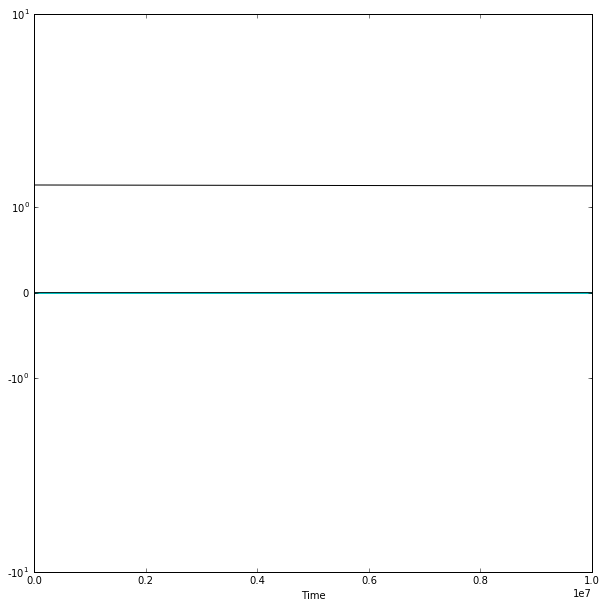

In [42]:
# Read boltzmann stochastic reaction likelihoods
ode_derivatives = pd.read_table('neurospora_pentose_phos.glycolysis.tca.2_no_reg.ode_dconcs',header=0,index_col=0)
# Get the absolute value of the derivatives:
abs_derivatives = np.abs(ode_derivatives.iloc[-1,:])
display(abs_derivatives.sort_values())
#plt.figure();ode_derivatives.iloc[-5000:-1500,:].plot(legend=False,logx=True,logy=False,figsize=(10, 10))
plt.figure();ode_derivatives.plot(legend=False,logx=False,logy=False,figsize=(10, 10))
plt.yscale('symlog')
#plt.legend(bbox_to_anchor=(1.35, 1.05),bbox_transform=plt.gcf().transFigure)

The values reported in the paper are those obtained just before the solver became unstable, at relative time 9.250000e+09.

In [43]:
#display(ode_derivatives.loc[9.250000e+09].sort_values())

### Thermodynamic Odds of Reaction from Deterministic Simulation
The thermodynamic likelihoods are read in from the output files, where the likelihood is $e^{A_{\alpha}/RT} = K_{\alpha}Q_{\alpha}^{-1}$. $A_{\alpha}$ is the reaction affinity for reaction $\alpha$, $K_{\alpha}$ is the equilibrium constant, and $Q_{\alpha}$ is the reaction quotient.

ME1m                    0.000000
ME2m                    0.000000
CSm                     6.554156
ACONTm                  6.703329
ICDHxm                  6.582371
AKGDm                   6.582372
SUCOASm                 6.703335
SUCD1m                  6.703332
FUMm                    6.703327
MDHm                    6.554156
GAPD                    7.933921
PGK                     7.933929
TPI                     4.145176
MDH                     0.000000
PEP_Carboxylase         0.000000
PPCK                    0.000000
FBA                     4.145176
FBP                     0.000000
TKT2                    0.000000
RPE                     0.000000
Xylulokinase            0.000000
PYK_org                 0.000000
PYK                     7.933929
RPI                     0.000000
TKT1                    0.000000
TALA                    0.000000
PGM                     7.933930
ENO                     7.933930
GND                     0.000000
PGL                     0.000000
HEX1      

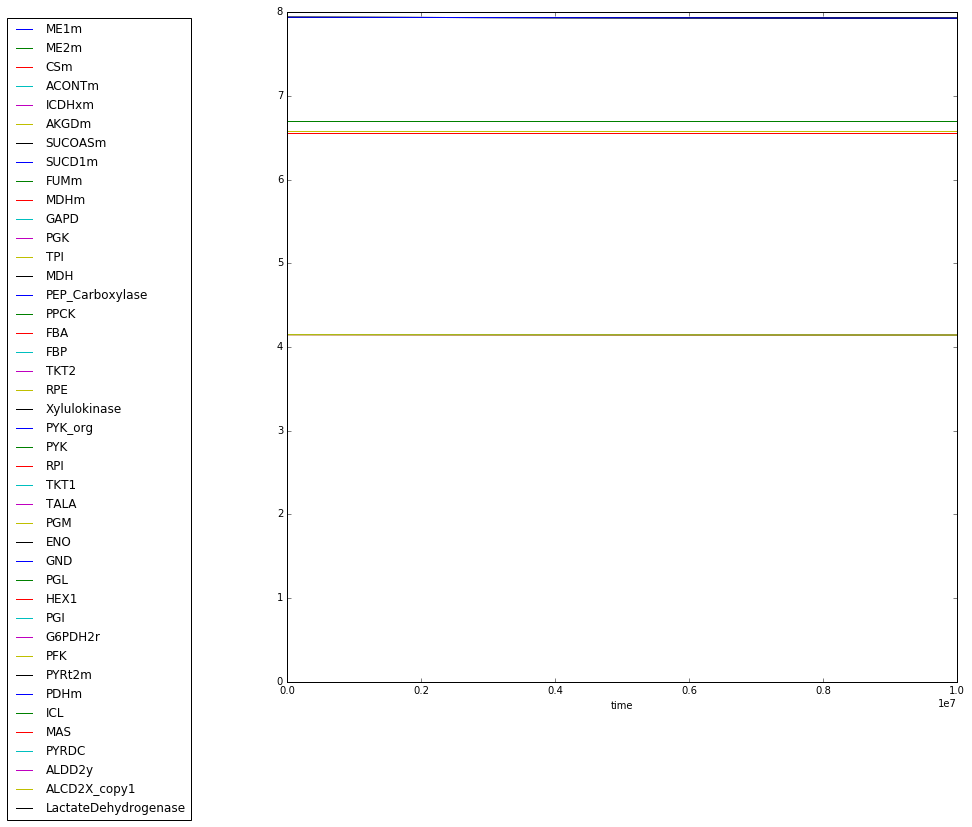

In [44]:
# Read boltzmann ODE reaction likelihoods
ode_likelihoods_timeseries = pd.read_table('neurospora_pentose_phos.glycolysis.tca.2_no_reg.ode_lklhd',header=1, index_col = 0, quoting=2)

temp = [x for x in ode_likelihoods_timeseries.columns if 'f_' in x]
ode_fwd_likelihoods_timeseries = ode_likelihoods_timeseries[temp]
temp = [x for x in ode_likelihoods_timeseries.columns if 'r_' in x]
ode_rev_likelihoods_timeseries = ode_likelihoods_timeseries[temp]

ode_fwd_likelihoods_timeseries.columns = [x.split("f_")[-1] for x in ode_fwd_likelihoods_timeseries.columns]
ode_rev_likelihoods_timeseries.columns = [x.split("r_")[-1] for x in ode_rev_likelihoods_timeseries.columns]

plt.figure()
ode_fwd_likelihoods_timeseries.plot(legend=False,logx=False,figsize=(12, 12))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(bbox_to_anchor=(0.02, 0.9),bbox_transform=plt.gcf().transFigure)
#display(ode_fwd_likelihoods_timeseries.loc[:9.250000e+09].mean())
display(ode_fwd_likelihoods_timeseries.mean())

As mentioned above, when the the derivatives for acetyl-CoA go below 0.05, the solver becomes unstable because even a small time step results in a large change the derivative. However, the likelihoods  are sufficiently converged at this point that good estimates of the steady state reaction fluxes can be obtained. 

### Calculate Net Odds
The net odds of a reaction are proportional to the reaction flux. To get the steady state values of the likelihoods, we'll use the average of the last 30 steps before the solver became unstable (relative time from 9.247000e+09 to 9.250000e+09).

In [45]:
#ode_likelihoods_steadystate = pd.DataFrame(data = ode_fwd_likelihoods_timeseries.loc[9.247000e+09:9.250000e+09].mean(), 
ode_likelihoods_steadystate = pd.DataFrame(data = ode_fwd_likelihoods_timeseries.mean(), 
                                           index = ode_fwd_likelihoods_timeseries.columns,
                                          columns =['Forward'])
#ode_likelihoods_steadystate['Reverse'] = ode_rev_likelihoods_timeseries.loc[9.247000e+09:9.250000e+09].mean()
ode_likelihoods_steadystate['Reverse'] = ode_rev_likelihoods_timeseries.mean()
#ode_likelihoods_steadystate['Reverse'] = ode_likelihoods_steadystate['Forward'].rdiv(1)
ode_likelihoods_steadystate['For-Rev'] = ode_likelihoods_steadystate['Forward'] - ode_likelihoods_steadystate['Reverse']
ode_likelihoods_steadystate['Rxn Probabilities'] = ode_likelihoods_steadystate['For-Rev']/np.sum(abs(ode_likelihoods_steadystate['For-Rev']))
display(ode_likelihoods_steadystate)

,Forward,Reverse,For-Rev,Rxn Probabilities
ME1m,0.000000,0.000000e+00,0.000000,0.000000
ME2m,0.000000,0.000000e+00,0.000000,0.000000
CSm,6.554156,5.290375e-14,6.554156,0.051767
ACONTm,6.703329,1.491725e-01,6.554156,0.051767
ICDHxm,6.582371,2.821428e-02,6.554157,0.051767
AKGDm,6.582372,2.821556e-02,6.554156,0.051767
SUCOASm,6.703335,1.491783e-01,6.554157,0.051767
SUCD1m,6.703332,1.491752e-01,6.554157,0.051767
FUMm,6.703327,1.491710e-01,6.554156,0.051767
MDHm,6.554156,5.290088e-14,6.554156,0.051767


### Map Net Likelihoods onto Metabolic Pathways

In [46]:
from escher import Builder

reaction_data = ode_likelihoods_steadystate['For-Rev'].to_dict()
#b = Builder(map_name="iMM904.PPP_TCA_Glycolysis.json",reaction_data=reaction_data)
b = Builder(map_name="iMM904.compact_Glycolysis_TCA_PPP.json",reaction_data=reaction_data)
#b.display_in_browser(menu='all')
b.display_in_notebook(menu='zoom')

### Find Active and Variable Metabolites
Some metabolites concentrations are parameters - those that form the boundary conditions such as cofactors, glucose and CO$_{2}$ - and others are free variables. Here we find the subset of metabolites that are free variables.

In [47]:
# Find active reactions
# find chemicals that are in at least one reaction. Includes chemicals that are fixed as well as
# variable ones:
S_active = pd.read_table('neurospora_pentose_phos.glycolysis.tca.2_no_reg.amat',header=0, index_col = 0, quoting=2)
del S_active['forward reaction']

active_metabolites_idx = (S_active != 0).any(axis=0) #any searches down the column
inactive_metabolites_idx = ~active_metabolites_idx

metabolites_status = pd.read_csv('neurospora_pentose_phos.glycolysis.tca.2_no_reg.rstrt',delimiter = '\t', index_col=0,skiprows = 2, header=None,quoting=2,usecols=[0,2])
metabolites_status.rename(columns={2:'Value'},inplace=True)
metabolites_status.index = metabolites_status.index.str.strip()
metabolites_status['Variable?'] = metabolites_status == 'V'
metabolites_status.insert(1,'Active?',active_metabolites_idx.values)
del metabolites_status['Value']

metabolites_status['Variable & Active'] = metabolites_status['Variable?']&metabolites_status['Active?']
variable_metabolite_idx = list(metabolites_status[metabolites_status['Variable & Active']==True].index)
variable_metabolite_idx = list(map(str.strip, variable_metabolite_idx))

### Time Derivatives of Metabolite Concentration: S $\cdot$ Net Odds = flux
This is a demonstration that the product of the stoichiometric matrix S and the net thermodynamic odds are close to zero, which is the steady state condition discussed in the manuscript. Here the stoichiometric matrix $S^{m,n}$is defined as $m$ reactions by $n$ metabolites, which is the transpose of how it is used in the metabolic modeling literature.

In [48]:
S = pd.read_table('neurospora_pentose_phos.glycolysis.tca.2_no_reg.mat',header=0, index_col = 0, quoting=2)
del S['forward reaction']

S = S.astype(np.float64)
# S.T.dot(ode_likelihoods_steadystate['For-Rev']) =  time derivative of concentrations
#                                                    0 at steady state and maximum entropy.
# If boundary conditions prevent maximum entropy, then the flux !=0 for boundary species.
derivatives2 = (S.T.dot(ode_likelihoods_steadystate['For-Rev'])).sort_values()
display(derivatives2[variable_metabolite_idx].sort_values())

CITRATE:MITOCHONDRIA                      -4.990009e-07
SUCCINYL-COA:MITOCHONDRIA                 -2.600002e-07
ISOCITRATE:MITOCHONDRIA                   -2.200002e-07
SUCCINATE:MITOCHONDRIA                    -9.900094e-08
D-GLYCERALDEHYDE-3-PHOSPHATE:CYTOSOL      -2.457542e-08
BETA-D-GLUCOSE-6-PHOSPHATE:CYTOSOL        -1.108892e-08
2-PHOSPHO-D-GLYCERATE:CYTOSOL             -6.193806e-09
PHOSPHOENOLPYRUVATE:CYTOSOL               -1.598404e-09
(S)-MALATE:MITOCHONDRIA                   -9.989307e-10
OXALOACETATE:MITOCHONDRIA                  0.000000e+00
GLYCERONE_PHOSPHATE:CYTOSOL                1.098900e-09
D-FRUCTOSE_6-PHOSPHATE:CYTOSOL             5.944056e-08
3-PHOSPHO-D-GLYCERATE:CYTOSOL              7.042957e-08
3-PHOSPHO-D-GLYCEROYL_PHOSPHATE:CYTOSOL    2.501498e-07
2-OXOGLUTARATE:MITOCHONDRIA                2.800002e-07
PYRUVATE:CYTOSOL                           5.807193e-07
FUMARATE:MITOCHONDRIA                      7.990009e-07
PYRUVATE:MITOCHONDRIA                      8.989

### Analyze Variable Metabolite Levels from Deterministic Simulation

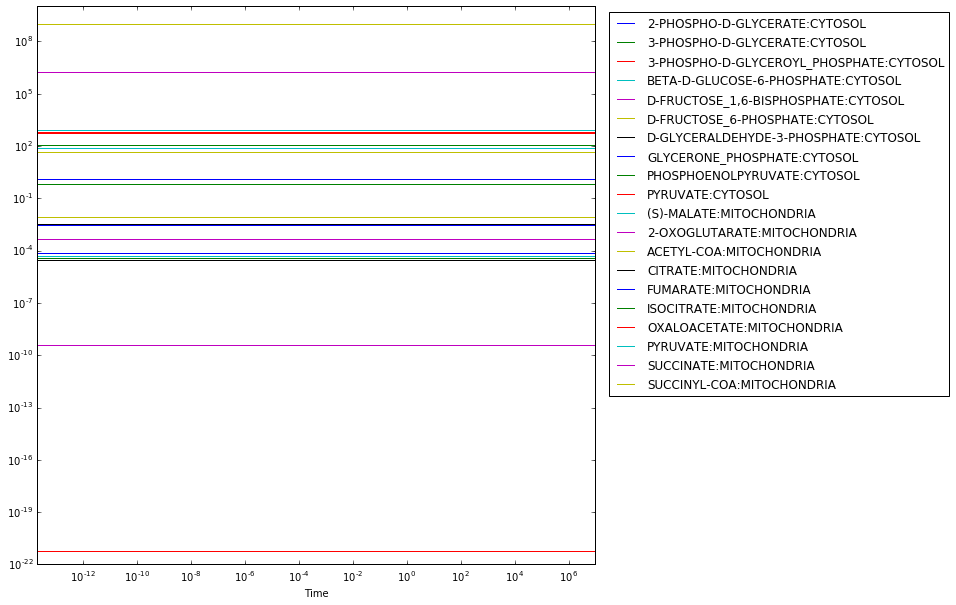

In [49]:
# Read boltzmann stochastic reaction likelihoods
ode_metabolites = pd.read_table('neurospora_pentose_phos.glycolysis.tca.2_no_reg.ode_concs',header=0,index_col=0)

fig = plt.figure();
plot = ode_metabolites[variable_metabolite_idx].plot(legend=False,logy=True,logx=True,figsize=(10, 10))
fig = plot.get_figure()
fig.savefig('metabolites_no_regulation.png')
plt.legend(bbox_to_anchor=(1.40, 0.90),bbox_transform=plt.gcf().transFigure)
fig.savefig('metabolites_no_regulation_legend.png',bbox_inches='tight')

In [50]:
ode_metabolites_steadystate = \
  pd.DataFrame(data = ode_metabolites.iloc[-20:,:].mean(),columns=['ODE'])
ode_metabolites_steadystate.sort_values(by=['ODE'])

,ODE
"D-GLUCONO-1,5-LACTONE_6-PHOSPHATE:CYTOSOL",0.000000e+00
LACTATE:CYTOSOL,0.000000e+00
6-PHOSPHO-D-GLUCONATE:CYTOSOL,0.000000e+00
ACETALDEHYDE:CYTOSOL,0.000000e+00
ACETATE:CYTOSOL,0.000000e+00
ETHANOL:CYTOSOL,0.000000e+00
OXALOACETATE:MITOCHONDRIA,5.723803e-22
2-OXOGLUTARATE:MITOCHONDRIA,3.787650e-10
D-ERYTHROSE-4-PHOSPHATE:CYTOSOL,5.149502e-08
D-RIBULOSE-5-PHOSPHATE:CYTOSOL,2.890365e-07


## Infer Regulated Reactions
Regulated reactions are inferred using a loss function defined as the log ratio of the observed values $n_{i(\alpha)}$ to the predicted values $\tilde{n}_{i(\alpha)}$ of the $M(\alpha )$ reaction products of reaction $\alpha$,
\[
L_{\alpha }=\log \prod\limits_{i(\alpha )}^{M(\alpha )}{\frac{n_{i(\alpha )}}{\tilde{n}_{i(\alpha )}}}.
\] 	

In [51]:
ode_metabolites_steadystate['Expected'] = 1.0e-03

S = pd.read_table('neurospora_pentose_phos.glycolysis.tca.2_no_reg.mat',header=0, index_col = 0, quoting=2)
P = (S>0)
del P['forward reaction']

P = P.astype(np.float64)
#display(R)
product_concentrations = P.multiply(ode_metabolites_steadystate['ODE'],axis=1)
product_concentrations[product_concentrations == 0] = 1
product_concentrations_rxns = pd.DataFrame(data = product_concentrations.T.product(), columns=['ODE'])
expect_product_concentrations = P.multiply(ode_metabolites_steadystate['Expected'],axis=1)
expect_product_concentrations[expect_product_concentrations == 0] = 1
product_concentrations_rxns['Expected'] = (expect_product_concentrations.T).product()

s_regulation = '$L_{reg}$'
product_concentrations_rxns[s_regulation] = \
    np.log(product_concentrations_rxns['ODE']/product_concentrations_rxns['Expected'])

idx = (ode_likelihoods_steadystate['Reverse'] != 0) & (ode_likelihoods_steadystate['Forward'] != 0) & \
            (product_concentrations_rxns[s_regulation]>1)
#display(product_concentrations_rxns[product_concentrations_rxns[s_regulation]>1])
display(product_concentrations_rxns[idx].sort_values(by=s_regulation))
product_concentrations_rxns[idx].to_csv(path_or_buf='loss_no_regulation.txt',sep='\t')

,ODE,Expected,$L_{reg}$
reaction title,,,
CSm,4.854560e-06,1.000000e-06,1.579919
SUCOASm,6.622119e-09,1.000000e-09,1.890415
ENO,6.645813e-01,1.000000e-03,6.499157
PGM,1.330016e+00,1.000000e-03,7.192947
HEX1,4.259995e-02,1.000000e-06,10.659608
PGI,4.584099e+01,1.000000e-03,10.732934
GAPD,4.816581e-02,1.000000e-06,10.782405
PYRt2m,8.427092e+02,1.000000e-03,13.644377
PGK,1.093091e+00,1.000000e-06,13.904520
